# SVDiff-pytorch
<a href="https://colab.research.google.com/github/mkshing/svdiff-pytorch/blob/main/scripts/svdiff_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is an implementation of [SVDiff: Compact Parameter Space for Diffusion Fine-Tuning](https://arxiv.org/abs/2303.11305) by using d🧨ffusers. 

- My summary tweet: https://twitter.com/mk1stats/status/1642865505106272257
- Code: https://github.com/mkshing/svdiff-pytorch


## **Setup**

In [ ]:
!nvidia-smi
!git clone https://mkshing@github.com/mkshing/svdiff-pytorch.git
!pip install -r svdiff-pytorch/requirements.txt
!pip install -q -U --pre triton
!pip install -q ftfy bitsandbytes==0.35.0 gradio natsort xformers

In [ ]:
# @markdown **(Optional) Login wandb**<br> If you don't use wandb for logging, make sure to remove `--report_to="wandb"`
!wandb login

In [ ]:
#@markdown **helper functions**
import io
import requests
import PIL
import torch
from torch import autocast
from diffusers import (
    LMSDiscreteScheduler, 
    DDIMScheduler, 
    PNDMScheduler,
    DPMSolverMultistepScheduler, 
    EulerDiscreteScheduler, 
    EulerAncestralDiscreteScheduler,
    StableDiffusionPipeline
)
from PIL import Image

def fetch(url_or_path):
    if str(url_or_path).startswith('http://') or str(url_or_path).startswith('https://'):
        r = requests.get(url_or_path)
        r.raise_for_status()
        fd = io.BytesIO()
        fd.write(r.content)
        fd.seek(0)
        return fd
    return open(url_or_path, 'rb')


def image_grid(imgs, rows, cols):
    assert len(imgs) == rows * cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols * w, rows * h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid

SCHEDULER_MAPPING = {
    "ddim": DDIMScheduler,
    "plms": PNDMScheduler,
    "lms": LMSDiscreteScheduler,
    "euler": EulerDiscreteScheduler,
    "euler_ancestral": EulerAncestralDiscreteScheduler,
    "dpm_solver++": DPMSolverMultistepScheduler,
}

## **Training SVDiff**

In this example, use 5 dog images as usual by downloading from [here](https://drive.google.com/drive/folders/1BO_dyz-p65qhBRRMRA4TbZ8qW4rB99JZ).

In [ ]:
#@title **Dataset**
import datetime
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


def display_pic(folder):
    fig = plt.figure(figsize=(30, 60))
    files = sorted(glob.glob(folder+'/*.jpg'))
    for i, file in enumerate(files):
        img = Image.open(file)    
        images = np.asarray(img)
        ax = fig.add_subplot(10, 5, i+1, xticks=[], yticks=[])
        image_plt = np.array(images)
        ax.imshow(image_plt)
        name = os.path.basename(file)
        ax.set_xlabel(name, fontsize=30)  
        fig.tight_layout()             
    plt.show()
    plt.close()


# save_image = True #@param {type:"boolean"}
mount_google_drive = True #@param {type:"boolean"}
INSTANCE_DATA_DIR = "/content/drive/MyDrive/AI/dreambooth-dog/data" #@param {type: 'string'}
CLASS_DATA_DIR = "/content/drive/MyDrive/AI/dreambooth-dog/class-data" #@param {type: 'string'}
OUTPUT_DIR = "/content/SVDiffOutput" #@param {type: 'string'}

if CLASS_DATA_DIR is None:
  CLASS_DATA_DIR = OUTPUT_DIR + "/class_data_dir"

force_remount = False
if mount_google_drive:
    from google.colab import drive # type: ignore
    try:
        drive_path = "/content/drive"
        drive.mount(drive_path, force_remount=force_remount)
        # output_path_gdrive = f"/content/drive/MyDrive/{save_dir}"
        # save_dir = output_path_gdrive
    except:
        print("...error mounting drive or with drive path variables")
        print("...reverting to default path variables")
OUTPUT_DIR = os.path.abspath(OUTPUT_DIR)
os.makedirs(OUTPUT_DIR, exist_ok=True)
print(f"INSTANCE_DATA_DIR: {INSTANCE_DATA_DIR}")
print(f"CLASS_DATA_DIR: {CLASS_DATA_DIR}")
print(f"OUTPUT_DIR: {OUTPUT_DIR}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
INSTANCE_DATA_DIR: /content/drive/MyDrive/AI/dreambooth-dog/data
CLASS_DATA_DIR: /content/drive/MyDrive/AI/dreambooth-dog/class-data
OUTPUT_DIR: /content/SVDiffOutput


In [ ]:
# @title **Parameters:**
MODEL_NAME = "runwayml/stable-diffusion-v1-5" # @param ["runwayml/stable-diffusion-v1-5"]
# this is the number nitrosoke recommends 
NUM_CLASS_IMAGES = 200 #@param {type: "integer"}
MAX_TRAIN_STEPS = 800 #@param {type: "integer"}
CHECKPOINTING_STEPS = 200 #@param {type: "integer"}

In [ ]:
from accelerate.utils import write_basic_config
write_basic_config()

PosixPath('/root/.cache/huggingface/accelerate/default_config.yaml')

In [ ]:
# @title **Train:**
! accelerate launch svdiff-pytorch/train_svdiff.py \
  --pretrained_model_name_or_path=$MODEL_NAME \
  --instance_data_dir=$INSTANCE_DATA_DIR \
  --class_data_dir=$CLASS_DATA_DIR \
  --output_dir=$OUTPUT_DIR \
  --with_prior_preservation --prior_loss_weight=1.0 \
  --instance_prompt="photo of a sks dog" \
  --class_prompt="photo of a dog" \
  --resolution=512 \
  --train_batch_size=1 \
  --gradient_accumulation_steps=1 \
  --learning_rate=5e-3 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --num_class_images=$NUM_CLASS_IMAGES \
  --checkpointing_steps=$CHECKPOINTING_STEPS \
  --max_train_steps=$MAX_TRAIN_STEPS \
  --use_8bit_adam \
  --seed=42 \
  --enable_xformers_memory_efficient_attention \
  --gradient_checkpointing \
  # --report_to="wandb" \
  # --revision="fp16" \
  # --mixed_precision="fp16" \



### **Inference**

In [ ]:
# @markdown **Load model:**
import sys
sys.path.append("/content/svdiff-pytorch")
from svdiff_pytorch import load_unet_for_svdiff

spectral_shifts_ckpt = "/content/SVDiffOutput/checkpoint-800" #@param {type:"string"}
scheduler_type = "dpm_solver++" #@param ["ddim", "plms", "lms", "euler", "euler_ancestral", "dpm_solver++"]

device = "cuda" if torch.cuda.is_available() else "cpu"
unet = load_unet_for_svdiff(MODEL_NAME, spectral_shifts_ckpt=spectral_shifts_ckpt, subfolder="unet")

# load pipe
pipe = StableDiffusionPipeline.from_pretrained(
    MODEL_NAME,
    unet=unet,
    requires_safety_checker=False,
    safety_checker=None,
    feature_extractor=None,
    scheduler=SCHEDULER_MAPPING[scheduler_type].from_pretrained(MODEL_NAME, subfolder="scheduler")
)
pipe = pipe.to(device)
print("loaded pipeline")

seed: 515571909


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:57<00:00, 57.55s/it]


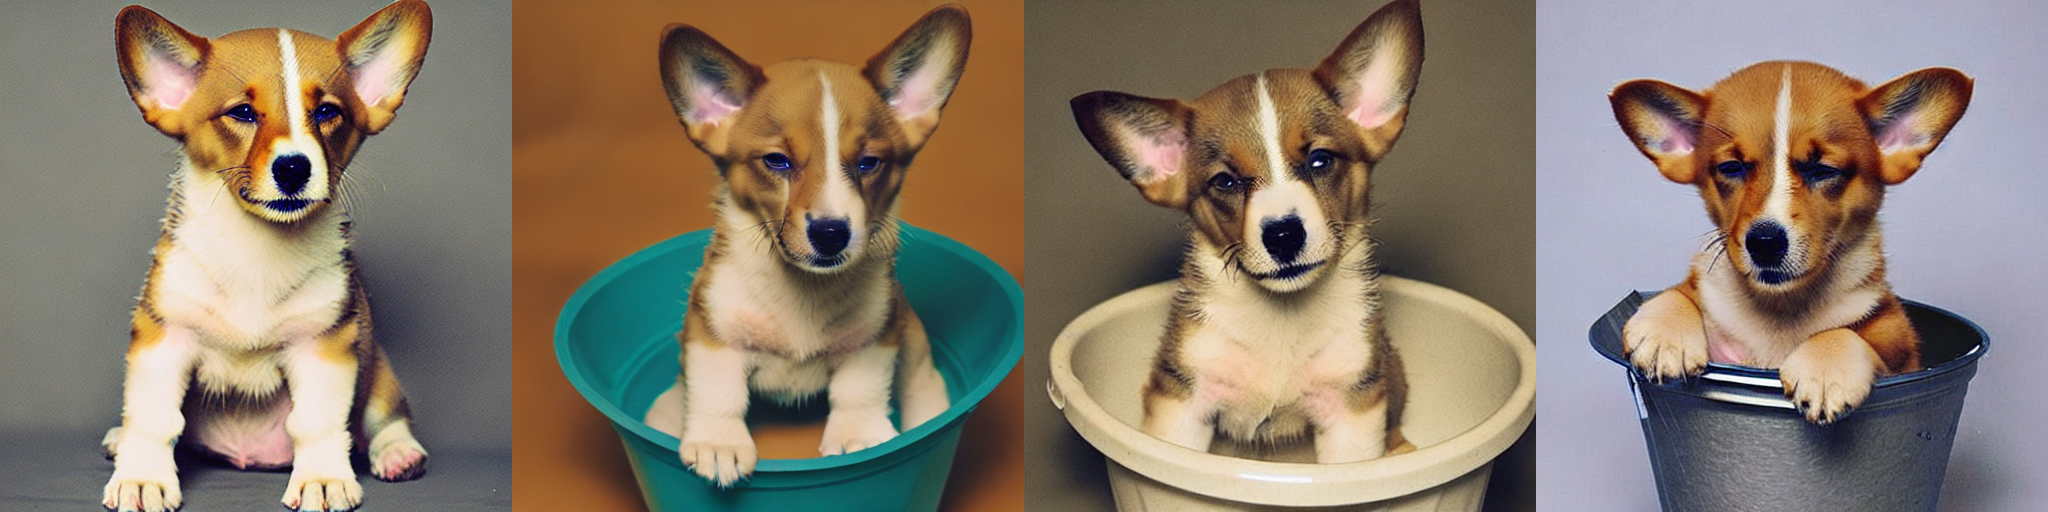

In [ ]:
# @markdown **Run!:**
# @markdown <br> *It takes time at the 1st run because SVD is performed. 
import random
from tqdm import tqdm

prompt = "A picture of a sks dog in a bucket" #@param {type:"string"}
num_images_per_prompt = 4 # @param {type: "integer"}
guidance_scale = 7.5 # @param {type: "number"}
num_inference_steps = 25 # @param {type: "integer"}
height = 512 # @param {type: "integer"}
width = 512 # @param {type: "integer"}
seed = "random_seed" #@param {type:"string"}
spectral_shifts_scale = 1.0 #@param {type: "number"}


if pipe.unet.conv_out.scale != spectral_shifts_scale:
  for module in pipe.unet.modules():
    if hasattr(module, "set_scale"):
      module.set_scale(scale=spectral_shifts_scale)
  print(f"Set spectral_shifts_scale to {spectral_shifts_scale}!")
  

if seed == "random_seed":
  random.seed()
  seed = random.randint(0, 2**32)
else:
  seed = int(seed)
g_cuda = torch.Generator(device='cuda').manual_seed(seed)
print(f"seed: {seed}")

prompts = prompt.split("::")
all_images = []
for prompt in tqdm(prompts):
    with torch.autocast(device), torch.inference_mode():
        images = pipe(
            prompt,
            num_inference_steps=num_inference_steps,
            guidance_scale=guidance_scale,
            num_images_per_prompt=num_images_per_prompt,
            height=height,
            width=width,
            generator=g_cuda
        ).images
    all_images.extend(images)
grid_image = image_grid(all_images, len(prompts), num_images_per_prompt)
grid_image

### **(Optional) Upload HuggingFace Hub**

In [ ]:
!huggingface-cli login

In [ ]:
from huggingface_hub import create_repo, upload_folder


hub_model_id = "svdiff-library/svdiff_dog_example" #@param {type: "string"}
hub_token = "" #@param {type: "string"}
folder_path = "/content/SVDiffOutput" #@param {type: "string"}

if hub_token == "":
  hub_token = None
repo_id = create_repo(repo_id=hub_model_id, exist_ok=True, token=hub_token).repo_id

base_model = MODEL_NAME
instance_prompt = "photo of a sks dog"  #@param {type: "string"}
# @markdown paste your `instace_prompt` here.

yaml = f"""
---
license: creativeml-openrail-m
base_model: {base_model}
instance_prompt: {instance_prompt}
tags:
- stable-diffusion
- stable-diffusion-diffusers
- text-to-image
- diffusers
- svdiff
inference: true
---
"""
model_card = f"""
# SVDiff-pytorch - {repo_id}
These are SVDiff weights for {base_model}. The weights were trained on {instance_prompt} using [DreamBooth](https://dreambooth.github.io/)."""
with open(os.path.join(folder_path, "README.md"), "w") as f:
    f.write(yaml + model_card)

upload_folder(
    repo_id=repo_id,
    folder_path=folder_path,
    commit_message="first commit",
    ignore_patterns=["step_*", "epoch_*"],
)



## **(Optional) Compare with LoRA**

In LoRA, the number of trainable parameters is 0.80 M by default. 

In [ ]:
# @title **LoRA**
!accelerate launch svdiff-pytorch/scripts/train_dreambooth_lora.py \
  --pretrained_model_name_or_path="CompVis/stable-diffusion-v1-4" \
  --instance_data_dir="/content/drive/MyDrive/AI/dreambooth-dog/data" \
  --class_data_dir="/content/drive/MyDrive/AI/dreambooth-dog/class-data" \
  --output_dir="/content/LoRAOutput" \
  --with_prior_preservation --prior_loss_weight=1.0 \
  --instance_prompt="photo of a sks dog" \
  --class_prompt="photo of a dog" \
  --resolution=512 \
  --train_batch_size=1 \
  --gradient_accumulation_steps=1 \
  --checkpointing_steps=100 \
  --learning_rate=1e-4 \
  --report_to="wandb" \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --num_class_images=200 \
  --max_train_steps=500 \
  --mixed_precision="fp16" \
  --gradient_checkpointing \
  --seed 42 \
  --push_to_hub \
  --validation_prompt="A photo of sks dog in a bucket" \
  --validation_epochs=50 \
  --hub_model_id="mshing/lora_dreambooth_dog_example"

In [ ]:
# @title **Inference LoRA**
from diffusers import DiffusionPipeline, DPMSolverMultistepScheduler
import torch

pipe = DiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", torch_dtype=torch.float16)
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
pipe.to("cuda")

pipe.unet.load_attn_procs("/content/LoRAOutput")
image = pipe("A picture of a sks dog in a bucket", num_inference_steps=25).images[0]
del pipe
torch.cuda.empty_cache()
image